# SolasAI Disparity Calculations

In [1]:
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
import solas_disparity as sd

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Building a Model

In [4]:
df = pd.read_csv("data/hmda.csv.gz", index_col="id")
df.sample(random_state=161803, n=5)

,Low-Priced,Interest Rate,Rate Spread,Loan Amount,Loan-to-Value Ratio,No Intro Rate Period,Intro Rate Period,Property Value,Income,Debt-to-Income Ratio,...,Hawaiian Or Pacific Islander,Hispanic,Non-Hispanic,Male,Female,Age >= 62,Age < 62,Race,Ethnicity,Sex
id,,,,,,,,,,,,,,,,,,,,,
13451,1.0,0.04875,0.00596,155000.0,0.9700,1,0,165000.0,35000.0,0.33,...,0.0,1.0,0.0,1.0,0.0,NaN,NaN,White,Hispanic,Male
18248,1.0,0.05750,0.01268,305000.0,1.0000,1,0,295000.0,60000.0,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown
19610,1.0,0.05500,0.01214,485000.0,0.9500,1,0,515000.0,100000.0,0.43,...,0.0,0.0,1.0,NaN,NaN,1.0,0.0,White,Non-Hispanic,Unknown
3339,1.0,0.03875,-0.00087,675000.0,1.0000,1,0,675000.0,190000.0,0.33,...,0.0,0.0,1.0,NaN,NaN,0.0,1.0,Black,Non-Hispanic,Unknown
19675,1.0,0.04375,0.00076,275000.0,0.3507,1,0,775000.0,209000.0,0.25,...,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown


In [5]:
features = [
    "Loan Amount",
    "Loan-to-Value Ratio",
    "Intro Rate Period",
    "Property Value",
    "Income",
    "Debt-to-Income Ratio",
    "Term 360",
    "Conforming",
]
label = "Interest Rate"

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size=0.25, random_state=161803)
test_index = y_test.index

In [6]:
xgb_regressor = xgb.XGBRegressor(
    max_depth=4,
    learning_rate=1.0,
    n_estimators=4,
    base_score=y_train.mean(),
    random_state=161803,
)
xgb_regressor.fit(X=X_train, y=y_train)

predictions = pd.Series(data=xgb_regressor.predict(X_test), index=X_test.index)
f"Model R^2: {metrics.r2_score(y_true=y_test, y_pred=predictions):0.3f}"

'Model R^2: 0.178'

Store arguments in a dictionary for reusability in multiple calls to disparity functions.

In [7]:
reused_arguments = dict(
    group_data=df.loc[test_index],
    protected_groups=["Black", "Asian", "Native American", "Hispanic", "Female"],
    reference_groups=["White", "White", "White", "Non-Hispanic", "Male"],
    group_categories=["Race", "Race", "Race", "Ethnicity", "Sex"],
    sample_weight=None,
)

## Adverse Impact Ratio (AIR)

In [8]:
air = sd.adverse_impact_ratio(
    outcome=predictions <= predictions.quantile(0.5),
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Adverse Impact Ratio

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ AIR Threshold                     │ 0.8                                                                         │
│ % Diff Threshold                  │ 0.0                                                                         │
│ Affected Groups                   │ Hispanic                                                                    │
│ Affected Reference                │ Non-Hispanic                                                                │
│ Affected Categories               │ Ethnicity                                                                   │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

## Adverse Impact Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,"4,322",13.56%,340.0,141.0,41.47%,9.70%,0.810,0.001,No,
Race,Asian,White,"4,322",13.56%,327.0,243.0,74.31%,-23.14%,1.452,0.000,No,
Race,Native American,White,"4,322",13.56%,20.0,9.0,45.00%,6.17%,0.879,0.657,No,
Race,White,,"4,322",13.56%,"3,623.0","1,854.0",51.17%,,,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,167.0,32.87%,21.54%,0.604,0.000,Yes,109.411765
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0","2,072.0",54.41%,,,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",414.0,40.04%,9.78%,0.804,0.000,No,
Sex,Male,,"2,656",46.88%,"1,622.0",808.0,49.82%,,,,,


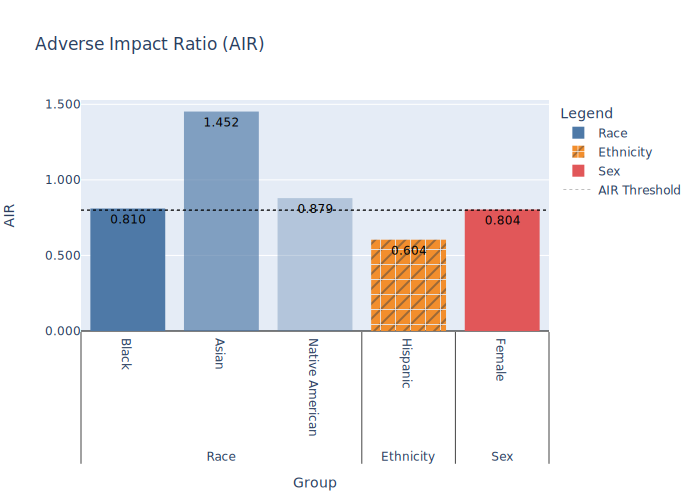

In [9]:
air

In [10]:
sd.ui.show(air.summary_table)

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,"4,322",13.56%,340.0,141.0,41.47%,9.70%,0.810,0.001,No,
Race,Asian,White,"4,322",13.56%,327.0,243.0,74.31%,-23.14%,1.452,0.000,No,
Race,Native American,White,"4,322",13.56%,20.0,9.0,45.00%,6.17%,0.879,0.657,No,
Race,White,,"4,322",13.56%,"3,623.0","1,854.0",51.17%,,,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,167.0,32.87%,21.54%,0.604,0.000,Yes,109.411765
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0","2,072.0",54.41%,,,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",414.0,40.04%,9.78%,0.804,0.000,No,
Sex,Male,,"2,656",46.88%,"1,622.0",808.0,49.82%,,,,,


## Standardized Mean Difference (SMD)

In [11]:
smd = sd.standardized_mean_difference(
    outcome=predictions,
    label=y_test,
    smd_threshold=30,
    lower_score_favorable=True,
    **reused_arguments,
)

## Disparity Calculation: SMD

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ SMD Threshold                     │ 30.0                                                                        │
│ Affected Groups                   │ Hispanic                                                                    │
│ Affected Reference                │ Non-Hispanic                                                                │
│ Affected Categories               │ Ethnicity                                                                   │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

## SMD Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Label,Average Outcome,Std. Dev. of Outcomes,SMD,P-Values,Practically Significant
Race,Black,White,"4,322",13.56%,340.0,0.05,0.05,0.00,27.559,0.000,No
Race,Asian,White,"4,322",13.56%,327.0,0.04,0.05,0.00,-70.355,0.000,No
Race,Native American,White,"4,322",13.56%,20.0,0.05,0.05,0.00,27.617,0.199,No
Race,White,,"4,322",13.56%,"3,623.0",0.05,0.05,0.00,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,0.05,0.05,0.00,43.545,0.000,Yes
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0",0.05,0.05,0.00,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",0.05,0.05,0.00,16.655,0.000,No
Sex,Male,,"2,656",46.88%,"1,622.0",0.05,0.05,0.00,,,


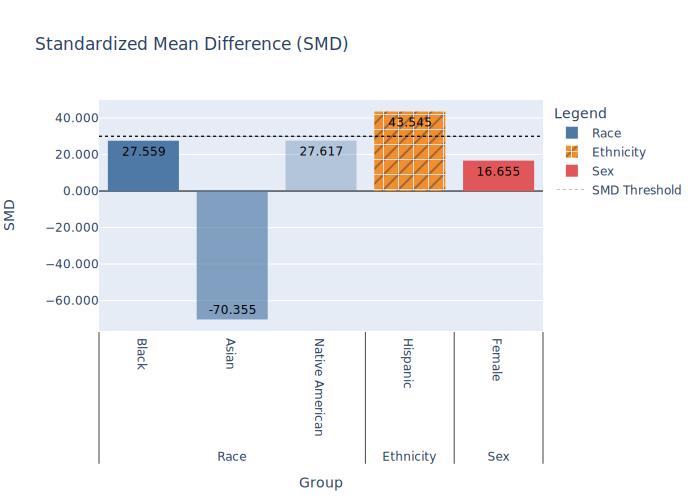

In [12]:
smd

In [13]:
sd.ui.show(smd.summary_table)

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Label,Average Outcome,Std. Dev. of Outcomes,SMD,P-Values,Practically Significant
Race,Black,White,"4,322",13.56%,340.0,0.05,0.05,0.00,27.559,0.000,No
Race,Asian,White,"4,322",13.56%,327.0,0.04,0.05,0.00,-70.355,0.000,No
Race,Native American,White,"4,322",13.56%,20.0,0.05,0.05,0.00,27.617,0.199,No
Race,White,,"4,322",13.56%,"3,623.0",0.05,0.05,0.00,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,0.05,0.05,0.00,43.545,0.000,Yes
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0",0.05,0.05,0.00,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",0.05,0.05,0.00,16.655,0.000,No
Sex,Male,,"2,656",46.88%,"1,622.0",0.05,0.05,0.00,,,


## Adverse Impact Ratio by Quantile

In [14]:
airq = sd.adverse_impact_ratio_by_quantile(
    outcome=predictions,
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    quantiles=[decile / 10 for decile in range(1, 11)],
    lower_score_favorable=True,
    **reused_arguments,
)

## Disparity Calculation: AIR by Quantile

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ AIR Threshold                     │ 0.8                                                                         │
│ % Diff Threshold                  │ 0.0                                                                         │
│ Affected Groups                   │ Black, Hispanic, Female                                                     │
│ Affected Reference                │ White, Non-Hispanic, Male                                                   │
│ Affected Categories               │ Race, Ethnicity, Sex                                                        │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

## AIR by Quantile Summary Table

Group Category,Group,Reference Group,Quantile,Quantile Cutoff,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,10.0%,0.044761,"4,322",13.56%,340.0,13.0,3.82%,4.93%,0.437,0.001,Yes,16.748827
Race,Asian,White,10.0%,0.044761,"4,322",13.56%,327.0,91.0,27.83%,-19.08%,3.181,0.000,No,
Race,Native American,White,10.0%,0.044761,"4,322",13.56%,20.0,1.0,5.00%,3.75%,0.571,1.000,No,
Race,White,,10.0%,0.044761,"4,322",13.56%,"3,623.0",317.0,8.75%,,,,,
Ethnicity,Hispanic,Non-Hispanic,10.0%,0.044761,"4,316",13.68%,508.0,15.0,2.95%,7.79%,0.275,0.000,Yes,39.561975
Ethnicity,Non-Hispanic,,10.0%,0.044761,"4,316",13.68%,"3,808.0",409.0,10.74%,,,,,
Sex,Female,Male,10.0%,0.044761,"2,656",46.88%,"1,034.0",66.0,6.38%,3.05%,0.677,0.006,Yes,31.535142
Sex,Male,,10.0%,0.044761,"2,656",46.88%,"1,622.0",153.0,9.43%,,,,,
Race,Black,White,20.0%,0.045863,"4,322",13.56%,340.0,37.0,10.88%,9.85%,0.525,0.000,Yes,33.477505
Race,Asian,White,20.0%,0.045863,"4,322",13.56%,327.0,132.0,40.37%,-19.64%,1.947,0.000,No,


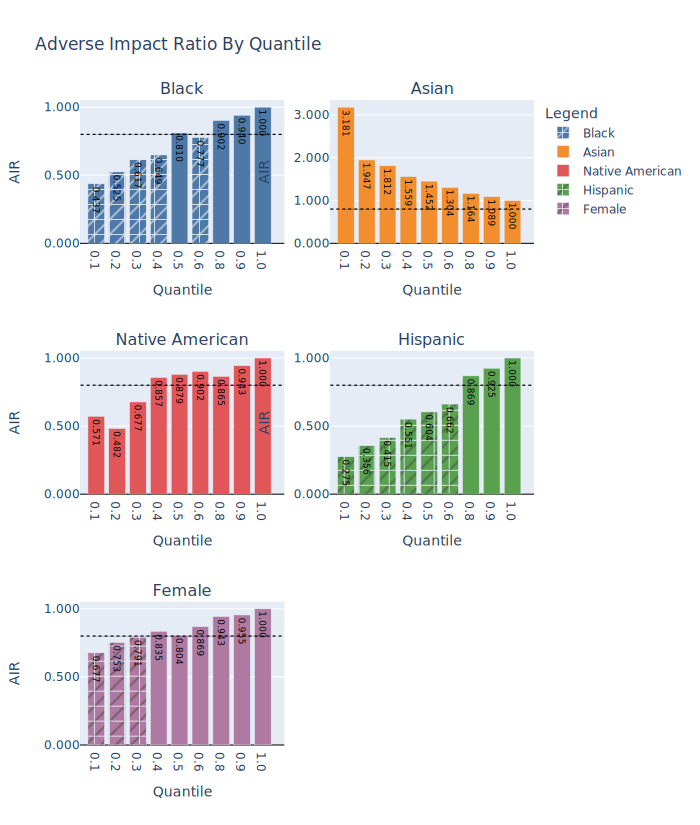

In [15]:
airq

In [16]:
sd.ui.show(airq.summary_table)

Group Category,Group,Reference Group,Quantile,Quantile Cutoff,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,10.0%,0.044761,"4,322",13.56%,340.0,13.0,3.82%,4.93%,0.437,0.001,Yes,16.748827
Race,Asian,White,10.0%,0.044761,"4,322",13.56%,327.0,91.0,27.83%,-19.08%,3.181,0.000,No,
Race,Native American,White,10.0%,0.044761,"4,322",13.56%,20.0,1.0,5.00%,3.75%,0.571,1.000,No,
Race,White,,10.0%,0.044761,"4,322",13.56%,"3,623.0",317.0,8.75%,,,,,
Ethnicity,Hispanic,Non-Hispanic,10.0%,0.044761,"4,316",13.68%,508.0,15.0,2.95%,7.79%,0.275,0.000,Yes,39.561975
Ethnicity,Non-Hispanic,,10.0%,0.044761,"4,316",13.68%,"3,808.0",409.0,10.74%,,,,,
Sex,Female,Male,10.0%,0.044761,"2,656",46.88%,"1,034.0",66.0,6.38%,3.05%,0.677,0.006,Yes,31.535142
Sex,Male,,10.0%,0.044761,"2,656",46.88%,"1,622.0",153.0,9.43%,,,,,
Race,Black,White,20.0%,0.045863,"4,322",13.56%,340.0,37.0,10.88%,9.85%,0.525,0.000,Yes,33.477505
Race,Asian,White,20.0%,0.045863,"4,322",13.56%,327.0,132.0,40.37%,-19.64%,1.947,0.000,No,


## Odds Ratio

In [17]:
odds_ratio = sd.odds_ratio(
    outcome=predictions <= predictions.quantile(0.5),
    odds_ratio_threshold=0.68,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Odds Ratio

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ Odds Ratio Threshold              │ 0.68                                                                        │
│ % Diff Threshold                  │ 0.0                                                                         │
│ Affected Groups                   │ Black, Hispanic, Female                                                     │
│ Affected Reference                │ White, Non-Hispanic, Male                                                   │
│ Affected Categories               │ Race, Ethnicity, Sex                                                        │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

## Odds Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Odds,Percent Difference Favorable,Odds Ratio,P-Values,Practically Significant
Race,Black,White,"4,322",13.56%,340.0,141.0,41.47%,0.708543,9.70%,0.676058,0.001,Yes
Race,Asian,White,"4,322",13.56%,327.0,243.0,74.31%,2.892857,-23.14%,2.760229,0.000,No
Race,Native American,White,"4,322",13.56%,20.0,9.0,45.00%,0.818182,6.17%,0.780671,0.657,No
Race,White,,"4,322",13.56%,"3,623.0","1,854.0",51.17%,1.048050,,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,167.0,32.87%,0.489736,21.54%,0.410319,0.000,Yes
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0","2,072.0",54.41%,1.193548,,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",414.0,40.04%,0.667742,9.78%,0.672700,0.000,Yes
Sex,Male,,"2,656",46.88%,"1,622.0",808.0,49.82%,0.992629,,,,


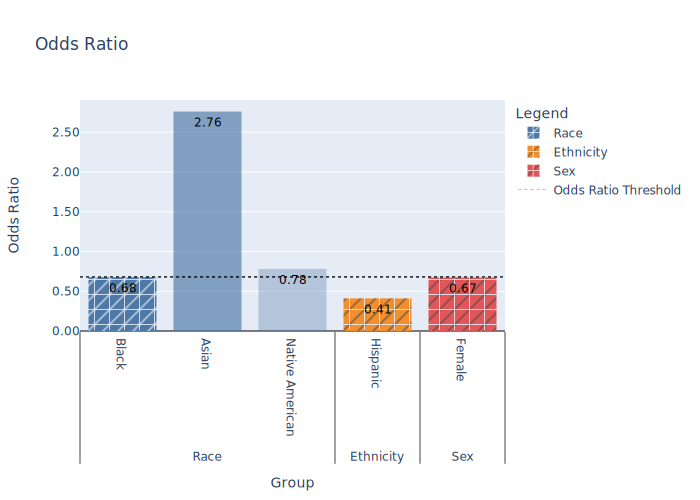

In [18]:
odds_ratio

In [19]:
sd.ui.show(odds_ratio.summary_table)

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Odds,Percent Difference Favorable,Odds Ratio,P-Values,Practically Significant
Race,Black,White,"4,322",13.56%,340.0,141.0,41.47%,0.708543,9.70%,0.676058,0.001,Yes
Race,Asian,White,"4,322",13.56%,327.0,243.0,74.31%,2.892857,-23.14%,2.760229,0.000,No
Race,Native American,White,"4,322",13.56%,20.0,9.0,45.00%,0.818182,6.17%,0.780671,0.657,No
Race,White,,"4,322",13.56%,"3,623.0","1,854.0",51.17%,1.048050,,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,167.0,32.87%,0.489736,21.54%,0.410319,0.000,Yes
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0","2,072.0",54.41%,1.193548,,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",414.0,40.04%,0.667742,9.78%,0.672700,0.000,Yes
Sex,Male,,"2,656",46.88%,"1,622.0",808.0,49.82%,0.992629,,,,


## Categorical Adverse Impact Ratio

Generate an example categorical outcome.

In [20]:
categorical_outcome = pd.qcut(predictions, q=[0.0, 0.25, 0.5, 0.75, 1.0])
categories = categorical_outcome.cat.categories.to_series()
categories = pd.Series(["Best", "Great", "Good", "Bad"], index=categories.index)
categorical_outcome.replace(categories.to_dict(), inplace=True)

In [21]:
cair = sd.categorical_adverse_impact_ratio(
    outcome=categorical_outcome,
    ordinal_categories=list(reversed(categories.tolist())),
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Categorical AIR

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ Affected Groups                   │ Asian                                                                       │
│ Affected Reference                │ White                                                                       │
│ Affected Categories               │ Race                                                                        │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

## Categorical AIR Summary Table

Group Category,Group,Reference Group,Category,Category Ordinality,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,Bad,0,"4,322",13.56%,340.0,92.0,27.06%,-7.96%,1.417,0.001,No,
Race,Asian,White,Bad,0,"4,322",13.56%,327.0,19.0,5.81%,13.29%,0.304,0.000,Yes,43.457632
Race,Native American,White,Bad,0,"4,322",13.56%,20.0,6.0,30.00%,-10.90%,1.571,0.250,No,
Race,White,,Bad,0,"4,322",13.56%,"3,623.0",692.0,19.10%,,,,,
Ethnicity,Hispanic,Non-Hispanic,Bad,0,"4,316",13.68%,508.0,144.0,28.35%,-10.83%,1.618,0.000,No,
Ethnicity,Non-Hispanic,,Bad,0,"4,316",13.68%,"3,808.0",667.0,17.52%,,,,,
Sex,Female,Male,Bad,0,"2,656",46.88%,"1,034.0",269.0,26.02%,-4.44%,1.206,0.010,No,
Sex,Male,,Bad,0,"2,656",46.88%,"1,622.0",350.0,21.58%,,,,,
Race,Black,White,Good,1,"4,322",13.56%,340.0,199.0,58.53%,-9.70%,1.199,0.001,No,
Race,Asian,White,Good,1,"4,322",13.56%,327.0,84.0,25.69%,23.14%,0.526,0.000,Yes,75.664091


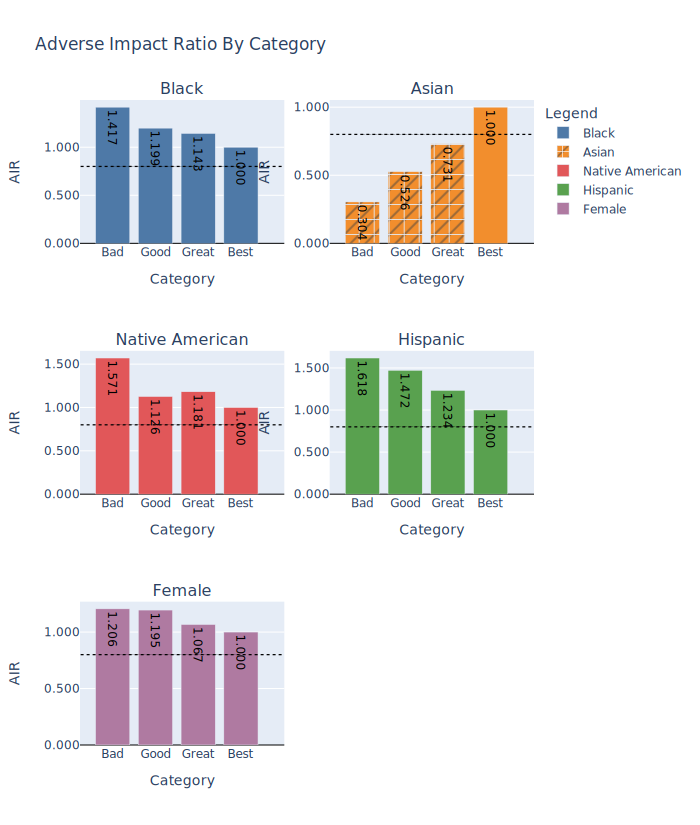

In [22]:
cair

In [23]:
sd.ui.show(cair.summary_table)

Group Category,Group,Reference Group,Category,Category Ordinality,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Black,White,Bad,0,"4,322",13.56%,340.0,92.0,27.06%,-7.96%,1.417,0.001,No,
Race,Asian,White,Bad,0,"4,322",13.56%,327.0,19.0,5.81%,13.29%,0.304,0.000,Yes,43.457632
Race,Native American,White,Bad,0,"4,322",13.56%,20.0,6.0,30.00%,-10.90%,1.571,0.250,No,
Race,White,,Bad,0,"4,322",13.56%,"3,623.0",692.0,19.10%,,,,,
Ethnicity,Hispanic,Non-Hispanic,Bad,0,"4,316",13.68%,508.0,144.0,28.35%,-10.83%,1.618,0.000,No,
Ethnicity,Non-Hispanic,,Bad,0,"4,316",13.68%,"3,808.0",667.0,17.52%,,,,,
Sex,Female,Male,Bad,0,"2,656",46.88%,"1,034.0",269.0,26.02%,-4.44%,1.206,0.010,No,
Sex,Male,,Bad,0,"2,656",46.88%,"1,622.0",350.0,21.58%,,,,,
Race,Black,White,Good,1,"4,322",13.56%,340.0,199.0,58.53%,-9.70%,1.199,0.001,No,
Race,Asian,White,Good,1,"4,322",13.56%,327.0,84.0,25.69%,23.14%,0.526,0.000,Yes,75.664091


## Residual Standardized Mean Difference

In [24]:
rsmd = sd.residual_standardized_mean_difference(
    prediction=predictions,
    label=y_test,
    residual_smd_threshold=30,
    lower_score_favorable=True,
    **reused_arguments,
)

## Disparity Calculation: Residual SMD

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ Affected Groups                   │                                                                             │
│ Affected Reference                │                                                                             │
│ Affected Categories               │                                                                             │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

## Residual SMD Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Prediction,Average Label,Average Residual,Std. Dev. of Residuals,Residual SMD,P-Values,Practically Significant
Race,Black,White,"4,322",13.56%,340.0,0.047486,0.05,0.000472,0.004864,5.445416,0.337,No
Race,Asian,White,"4,322",13.56%,327.0,0.045165,0.04,-0.000769,0.004864,-20.069041,0.000,No
Race,Native American,White,"4,322",13.56%,20.0,0.047487,0.05,0.000628,0.004864,8.646494,0.699,No
Race,White,,"4,322",13.56%,"3,623.0",0.046833,0.05,0.000207,0.004864,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,0.047667,0.05,0.001097,0.004864,21.513889,0.000,No
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0",0.046634,0.05,0.000051,0.004864,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",0.047268,0.05,0.000435,0.004864,5.047723,0.229,No
Sex,Male,,"2,656",46.88%,"1,622.0",0.046873,0.05,0.000189,0.004864,,,


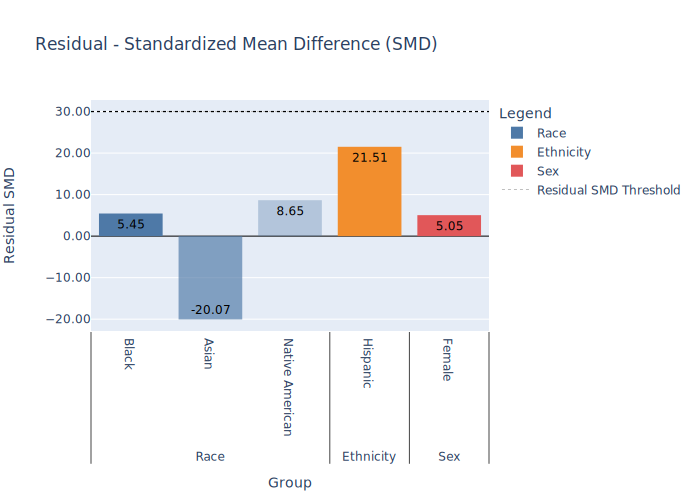

In [25]:
rsmd

In [26]:
sd.ui.show(rsmd.summary_table)

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Prediction,Average Label,Average Residual,Std. Dev. of Residuals,Residual SMD,P-Values,Practically Significant
Race,Black,White,"4,322",13.56%,340.0,0.047486,0.05,0.000472,0.004864,5.445416,0.337,No
Race,Asian,White,"4,322",13.56%,327.0,0.045165,0.04,-0.000769,0.004864,-20.069041,0.000,No
Race,Native American,White,"4,322",13.56%,20.0,0.047487,0.05,0.000628,0.004864,8.646494,0.699,No
Race,White,,"4,322",13.56%,"3,623.0",0.046833,0.05,0.000207,0.004864,,,
Ethnicity,Hispanic,Non-Hispanic,"4,316",13.68%,508.0,0.047667,0.05,0.001097,0.004864,21.513889,0.000,No
Ethnicity,Non-Hispanic,,"4,316",13.68%,"3,808.0",0.046634,0.05,0.000051,0.004864,,,
Sex,Female,Male,"2,656",46.88%,"1,034.0",0.047268,0.05,0.000435,0.004864,5.047723,0.229,No
Sex,Male,,"2,656",46.88%,"1,622.0",0.046873,0.05,0.000189,0.004864,,,


## Segmented Adverse Impact Ratio

Generate example income segments.

In [27]:
segments = pd.qcut(df.loc[test_index, "Income"], q=[0.0, 1 / 3, 2 / 3, 1.0])
categories = segments.cat.categories.to_series()
categories = pd.Series(["Low Income", "Mid Income", "High Income"], index=categories.index)
segments.replace(categories.to_dict(), inplace=True)

In [28]:
sair = sd.segmented_adverse_impact_ratio(
    outcome=predictions <= predictions.quantile(0.5),
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    fdr_threshold=0.2,
    segment=segments,
    **reused_arguments,
)

In [29]:
sair.summary_table

,Group Category,Group,Reference Group,Segment,Observations,Percent Missing,Total,Favorable,Percent Favorable,AIR,P-Values,Benjamani-Hochberg Critical Value,Practically Significant
0,Race,Black,White,Low Income,1510,0.117991,151.0,33.0,0.218543,0.839389,2.798899e-01,NaN,No
1,Race,Asian,White,Low Income,1510,0.117991,69.0,22.0,0.318841,1.224616,3.254284e-01,NaN,No
2,Race,Native American,White,Low Income,1510,0.117991,9.0,3.0,0.333333,1.280280,7.038812e-01,NaN,No
3,Race,White,,Low Income,1510,0.117991,1279.0,333.0,0.260360,NaN,NaN,NaN,
4,Ethnicity,Hispanic,Non-Hispanic,Low Income,1527,0.108061,242.0,40.0,0.165289,0.603400,2.927028e-04,NaN,Yes
5,Ethnicity,Non-Hispanic,,Low Income,1527,0.108061,1285.0,352.0,0.273930,NaN,NaN,NaN,
6,Sex,Female,Male,Low Income,1263,0.262266,528.0,107.0,0.202652,0.763840,1.214281e-02,NaN,No
7,Sex,Male,,Low Income,1263,0.262266,735.0,195.0,0.265306,NaN,NaN,NaN,
8,Race,Black,White,Mid Income,1414,0.131450,117.0,56.0,0.478632,0.905009,3.322955e-01,NaN,No
9,Race,Asian,White,Mid Income,1414,0.131450,89.0,67.0,0.752809,1.423428,3.629567e-05,NaN,No


In [30]:
sair.summary_table_by_segments

,Group Category,Group,Reference Group,Segment,Observations,Percent Missing,Total,Favorable,Percent Favorable,AIR,P-Values,Benjamani-Hochberg Critical Value,Practically Significant
0,Race,Black,White,Low Income,1510,0.117991,151.0,33.0,0.218543,0.839389,0.279890,NaN,No
1,Race,Asian,White,Low Income,1510,0.117991,69.0,22.0,0.318841,1.224616,0.325428,NaN,No
2,Race,Native American,White,Low Income,1510,0.117991,9.0,3.0,0.333333,1.280280,0.703881,NaN,No
3,Race,White,,Low Income,1510,0.117991,1279.0,333.0,0.260360,NaN,NaN,NaN,
4,Ethnicity,Hispanic,Non-Hispanic,Low Income,1527,0.108061,242.0,40.0,0.165289,0.603400,0.000293,NaN,Yes
5,Ethnicity,Non-Hispanic,,Low Income,1527,0.108061,1285.0,352.0,0.273930,NaN,NaN,NaN,
6,Sex,Female,Male,Low Income,1263,0.262266,528.0,107.0,0.202652,0.763840,0.012143,NaN,No
7,Sex,Male,,Low Income,1263,0.262266,735.0,195.0,0.265306,NaN,NaN,NaN,
8,Race,Black,White,Mid Income,1414,0.131450,117.0,56.0,0.478632,0.905009,0.332296,NaN,No
9,Race,Asian,White,Mid Income,1414,0.131450,89.0,67.0,0.752809,1.423428,0.000036,NaN,No


## Disparity Calculation: Segmented AIR

┌───────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                  │ Black, Asian, Native American, Hispanic, Female                             │
│ Reference Groups                  │ White, White, White, Non-Hispanic, Male                                     │
│ Group Categories                  │ Race, Race, Race, Ethnicity, Sex                                            │
│ AIR Threshold                     │ 0.8                                                                         │
│ % Diff Threshold                  │ 0.0                                                                         │
│ FDR Threshold                     │ 0.2                                                                         │
│ Segments                          │ ['Low Income', 'Mid Income', 'High Income']                                 │
│ Affected Groups                   │ Hispanic                                                                    │
│ Affected Reference                │ Non-Hispanic                                                                │
│ Affected Categories               │ Ethnicity                                                                   │
└───────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

## Segmented AIR Summary Table

Group Category,Group,Reference Group,Segment,Observations,Percent Missing,Total,Favorable,Percent Favorable,AIR,P-Values,Benjamani-Hochberg Critical Value,Practically Significant
Race,Black,White,Low Income,"1,510",11.80%,151.0,33.0,21.85%,0.839,0.280,,No
Race,Asian,White,Low Income,"1,510",11.80%,69.0,22.0,31.88%,1.225,0.325,,No
Race,Native American,White,Low Income,"1,510",11.80%,9.0,3.0,33.33%,1.280,0.704,,No
Race,White,,Low Income,"1,510",11.80%,"1,279.0",333.0,26.04%,,,,
Ethnicity,Hispanic,Non-Hispanic,Low Income,"1,527",10.81%,242.0,40.0,16.53%,0.603,0.000,,Yes
Ethnicity,Non-Hispanic,,Low Income,"1,527",10.81%,"1,285.0",352.0,27.39%,,,,
Sex,Female,Male,Low Income,"1,263",26.23%,528.0,107.0,20.27%,0.764,0.012,,No
Sex,Male,,Low Income,"1,263",26.23%,735.0,195.0,26.53%,,,,
Race,Black,White,Mid Income,"1,414",13.14%,117.0,56.0,47.86%,0.905,0.332,,No
Race,Asian,White,Mid Income,"1,414",13.14%,89.0,67.0,75.28%,1.423,0.000,,No


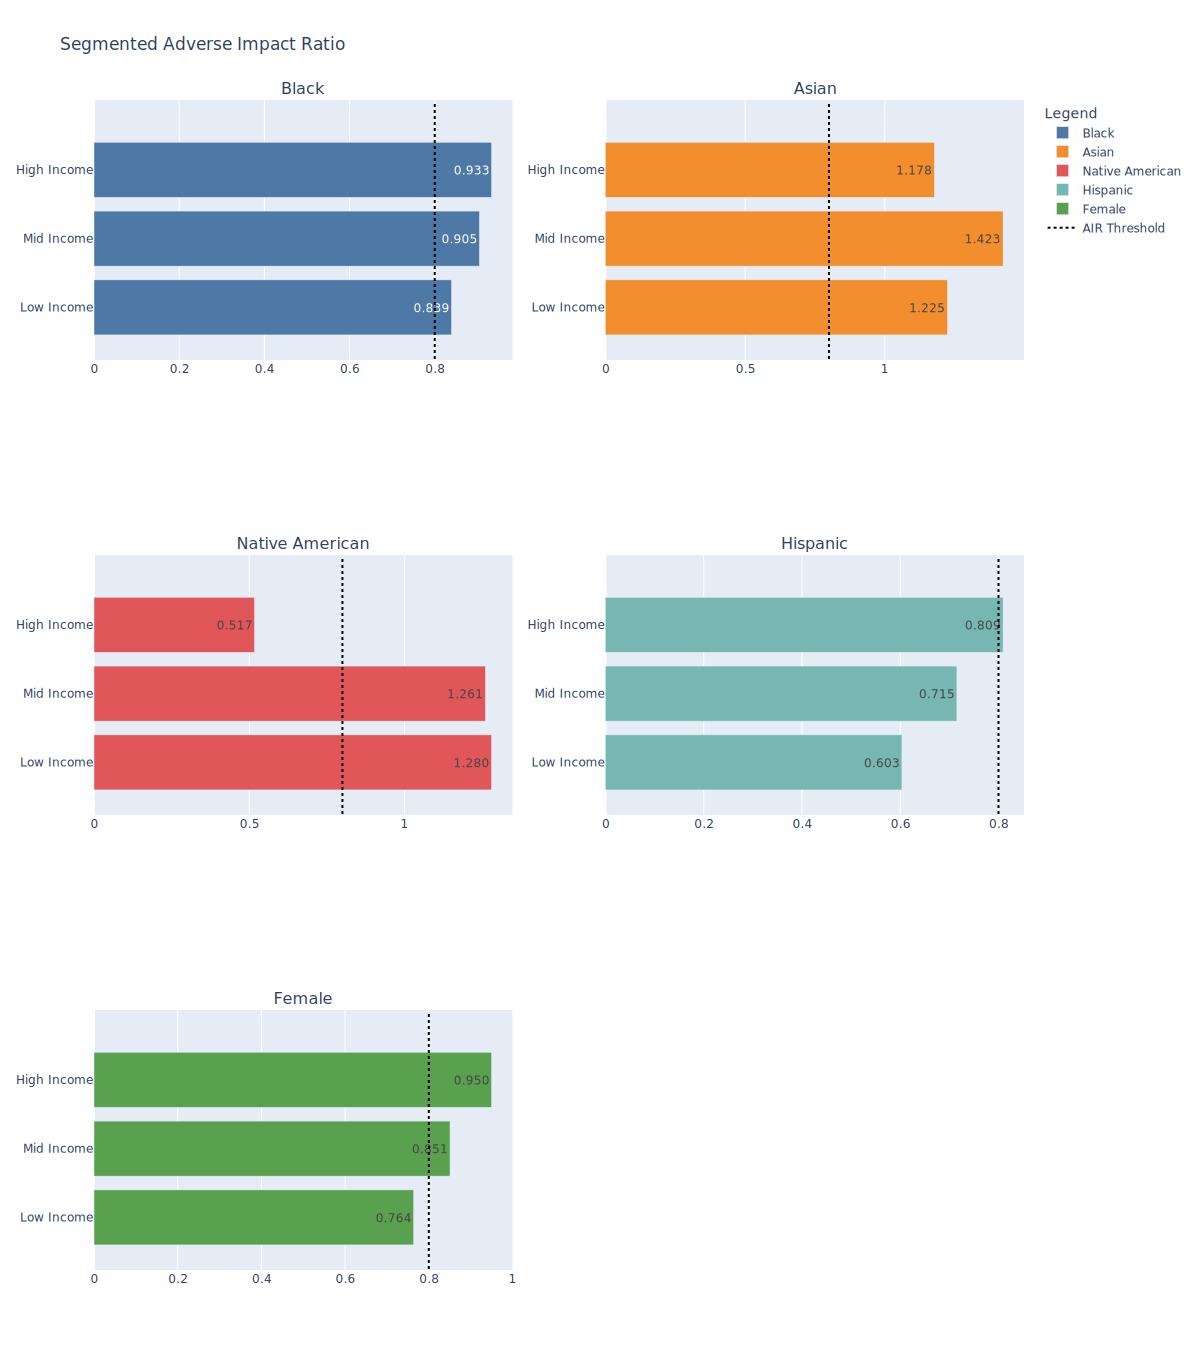

In [31]:
sair

In [32]:
sd.ui.show(sair.summary_table)

Group Category,Group,Reference Group,Segment,Observations,Percent Missing,Total,Favorable,Percent Favorable,AIR,P-Values,Benjamani-Hochberg Critical Value,Practically Significant
Race,Black,White,Low Income,"1,510",11.80%,151.0,33.0,21.85%,0.839,0.280,,No
Race,Asian,White,Low Income,"1,510",11.80%,69.0,22.0,31.88%,1.225,0.325,,No
Race,Native American,White,Low Income,"1,510",11.80%,9.0,3.0,33.33%,1.280,0.704,,No
Race,White,,Low Income,"1,510",11.80%,"1,279.0",333.0,26.04%,,,,
Ethnicity,Hispanic,Non-Hispanic,Low Income,"1,527",10.81%,242.0,40.0,16.53%,0.603,0.000,,Yes
Ethnicity,Non-Hispanic,,Low Income,"1,527",10.81%,"1,285.0",352.0,27.39%,,,,
Sex,Female,Male,Low Income,"1,263",26.23%,528.0,107.0,20.27%,0.764,0.012,,No
Sex,Male,,Low Income,"1,263",26.23%,735.0,195.0,26.53%,,,,
Race,Black,White,Mid Income,"1,414",13.14%,117.0,56.0,47.86%,0.905,0.332,,No
Race,Asian,White,Mid Income,"1,414",13.14%,89.0,67.0,75.28%,1.423,0.000,,No
